In [1]:
from collections import defaultdict
from pathlib import Path
import orjson as json
from tqdm import tqdm

arxiv_path = Path("/Users/jm/data/arxiv-metadata-oai-snapshot.json")
dataset = defaultdict(list)
max_size = 500000
with open(arxiv_path, "rb") as f:
    for i, line in enumerate(tqdm(f)):
        if i > max_size:
            break
        loaded_data = json.loads(line)
        dataset["title"].append(loaded_data["title"])
        dataset["abstract"].append(loaded_data["abstract"])
        dataset['id'].append(loaded_data['id'])
        dataset['doi'].append(loaded_data['doi'])
        dataset['categories'].append(loaded_data['categories'].split(" "))

500001it [00:02, 193713.99it/s]


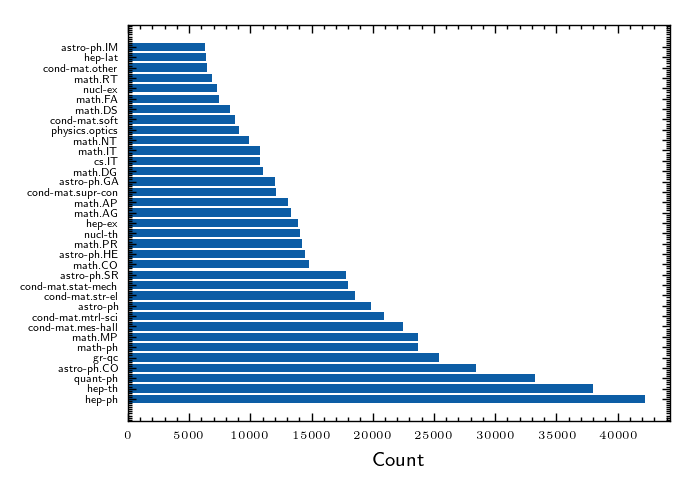

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

with plt.style.context(['nature', 'science']):
    max_cats = 35
    fig, axs = plt.subplots(1, 1, dpi=200)
    flat_categories = [y for x in dataset['categories'] for y in x]
    counter = Counter(flat_categories)
    vals = [x[1] for x in counter.most_common(max_cats)]
    cats = [x[0] for x in counter.most_common(max_cats)]
    axs.barh(cats, vals)
    axs.set_xlabel("Count")
    axs.tick_params(labelsize=4)

# Preparing the dataset

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
# download the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import pandas as pd

categories = ("math", "cs", "astro", "bio")
category_map = {category: i for i, category in enumerate(categories)}


def include_datapoint(category):
    for cand in categories:
        if cand in category:
            return cand
    return None


def equal_sampling(df, min_sample):
    category_counts = df['label'].value_counts()
    cats = category_counts.index
    counts = category_counts.values
    min_count = min(np.min(counts), min_sample)
    concat_dfs = []
    for cat in cats:
        concat_dfs.append(df[df['label'] == cat].sample(min_count))
    return pd.concat(concat_dfs)


MIN_EXAMPLES = 30
SAMPLE = 5000
MAX_LABLES = 6
dataset_pd = pd.DataFrame.from_dict(dataset)
dataset_pd['label_gt'] = dataset_pd['categories'].apply(lambda x: x[0])
dataset_pd['label'] = dataset_pd['label_gt'].apply(include_datapoint)
dataset_pd = dataset_pd.dropna()
dataset_pd['label_gt_cat'] = dataset_pd['label'].apply(
    lambda x: category_map[x])
dataset_pd = equal_sampling(dataset_pd, min_sample=300)

dataset_pd['label_gt_cat'].value_counts()

2    300
0    300
1    300
3    300
Name: label_gt_cat, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
import torch

MAX_LEN = 128
BATCH_SIZE = 64

train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    dataset_pd["id"].tolist(),
    dataset_pd["title"].tolist(),
    dataset_pd["label_gt_cat"].tolist(),
    test_size=.2)

train_encodings = tokenizer(train_queries,
                            train_docs,
                            truncation=True,
                            padding='max_length',
                            max_length=MAX_LEN)
val_encodings = tokenizer(val_queries,
                          val_docs,
                          truncation=True,
                          padding='max_length',
                          max_length=MAX_LEN)


class ArxivDataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = ArxivDataset(train_encodings, train_labels)
val_dataset = ArxivDataset(val_encodings, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False)


# Training the transfomer model

In [8]:
from transformers import BertForSequenceClassification, BertConfig

device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'mps')
# activate training mode of model

config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = max(category_map.values()) + 1
model = BertForSequenceClassification(config).to(device)

model.train()

optim = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 10

# begin training loop
for epoch in range(EPOCHS):
    loss_accm = 0
    test_acc = 0
    running_ex_size = 0
    for i, batch in enumerate(tqdm(train_dataloader)):
        # note that we move everything to the MPS device
        batch_mps = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # train model on batch and return outputs (incl. loss)
        outputs = model(**batch_mps)
        # extract loss
        loss = outputs[0]
        loss_accm += loss.item()
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        running_ex_size += batch['input_ids'].shape[0]
        test_acc += (
            outputs[1].cpu().argmax(1) == batch['labels']).sum().item()
        if i and (i % 100 == 0):
            print(
                f"Epoch {epoch} Batch {i} accuracy {test_acc/running_ex_size}")
    print(f"Epoch {epoch} loss: {loss_accm}")
    print(f"Epoch {epoch} accuracy: {test_acc/len(train_dataset)}")

100%|██████████| 15/15 [02:23<00:00,  9.56s/it]


Epoch 0 loss: 21.021209120750427
Epoch 0 accuracy: 0.25833333333333336


100%|██████████| 15/15 [01:58<00:00,  7.93s/it]


Epoch 1 loss: 20.912245869636536
Epoch 1 accuracy: 0.25625


100%|██████████| 15/15 [02:12<00:00,  8.86s/it]


Epoch 2 loss: 20.852153420448303
Epoch 2 accuracy: 0.278125


100%|██████████| 15/15 [02:06<00:00,  8.45s/it]


Epoch 3 loss: 20.72599196434021
Epoch 3 accuracy: 0.278125


  7%|▋         | 1/15 [00:08<01:54,  8.21s/it]


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    test_acc = 0
    for batch in tqdm(val_dataloader):
        batch_mps = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        outputs = model(**batch_mps)
        test_acc += (
            outputs[1].cpu().argmax(1) == batch['labels']).sum().item()
    print(f"Test accuracy: {test_acc/len(val_dataset)}")


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Test accuracy: 0.125
